# Saab Classifier
Classify your Saab (Categories: 900, 9000, 9-3, 9-5)

## Datafolders

In [1]:
from fastai2.vision.all import *
from fastai2.vision.widgets import *

In [2]:
PROJEKT_BASE_PATH = Path('./')
DATA_PATH = PROJEKT_BASE_PATH/'data'
list(PROJEKT_BASE_PATH.ls()), list(DATA_PATH.ls())

([Path('saab-classifier.pkl'),
  Path('saab-model-classifier.pkl'),
  Path('.git'),
  Path('app'),
  Path('models'),
  Path('brew_doctor.txt'),
  Path('SaabModelClassifier-v2.ipynb'),
  Path('Pipfile'),
  Path('bike.jpg'),
  Path('.ipynb_checkpoints'),
  Path('.vscode'),
  Path('setup_env.py'),
  Path('data'),
  Path('export.pkl'),
  Path('cleaner.pkl'),
  Path('SaabModelClassifier.ipynb'),
  Path('.gitignore'),
  Path('SaabModelClassifier-v2-01.ipynb'),
  Path('requirements.txt'),
  Path('Deploy_Model.ipynb'),
  Path('image_urls')],
 [Path('data/Saab_9-3'),
  Path('data/saab-model-classifier-cleaned-20200203.zip'),
  Path('data/Saab_900'),
  Path('data/Saab_9-5'),
  Path('data/Saab_9000')])

## Download Images
Images are downloaded into the root folder of drive to prevent local synchronisation!

This is from the v-3 of the fastai-course

In [ ]:
folders = ['Saab_9000', 'Saab_900', 'Saab_9-3', 'Saab_9-5']
files = ['saab9000.csv', 'saab900.csv', 'saab93.csv', 'saab95.csv']
classes = ['Saab_9000', 'Saab_900', 'Saab_9-3', 'Saab_9-5']

In [ ]:
# Run only when downloading the images
#path = Path('data')/Path('saab-model-classifier')
#path.mkdir(parents=True, exist_ok=True)

In [ ]:
# Download Images
#for i, n in enumerate(classes):
#  print(n)
#  path_f = PROJEKT_BASE_PATH/Path('image_urls')/Path(files[i])
#  download_images(path/n, path_f, max_pics=700)

In [ ]:
(PROJEKT_BASE_PATH/Path('image_urls')).ls()

In [ ]:
# And check they are all good. If not, we will delete them
imgs = L()
for n in classes:
    print(n)
    path_n = DATA_PATH/n
    imgs += verify_images(path_n.ls())

In [ ]:
for im in imgs:
    im.unlink()

In [ ]:
# Let's double check
imgs = L()
for n in classes:
    print(n)
    path_n = DATA_PATH/n
    imgs += verify_images(path_n.ls())

In [ ]:
path = DATA_PATH
path.ls()

## Create Dataloaders

In [3]:
batch_tfms = [*aug_transforms(size=224, max_warp=0, do_flip=True), Normalize.from_stats(*imagenet_stats)]
item_tfms = [Resize(224, ResizeMethod.Pad, pad_mode='zeros')]
item_tfms = [RandomResizedCrop(128, min_scale=0.4)]
bs=64

In [4]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=1234),
    get_y=parent_label,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

In [5]:
dls = cars.dataloaders(DATA_PATH, bs=bs)

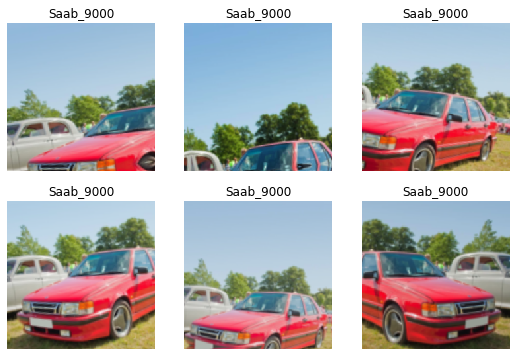

In [6]:
dls.train.show_batch(max_n=6, unique=True)

## Train the Model
I am already using a cleaned dataset.

In [7]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.914737,1.458828,0.450292,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.227817,1.202577,0.380117,00:14
1,1.043030,1.158521,0.331384,00:13
2,0.879899,1.068153,0.304094,00:14
3,0.715998,0.826693,0.222222,00:14
4,0.587074,0.788602,0.228070,00:14
5,0.469283,0.774388,0.214425,00:14
6,0.379990,0.707530,0.191033,00:14
7,0.320621,0.702266,0.202729,00:14


Let's look at the confusion Matrix

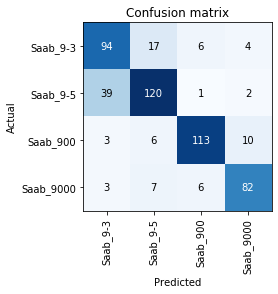

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

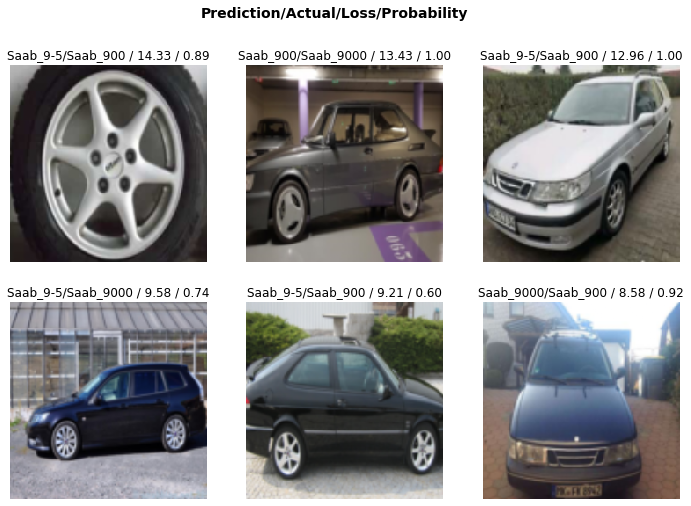

In [9]:
interp.plot_top_losses(6, nrows=2, figsize=(12, 8) )

### Optionally clean the Dataset

I won't do this because I am already using a cleaned dataset.

In [10]:
cleaner = ImageClassifierCleaner(learn, max_n=1500)
cleaner

In [15]:
len(dls.train_ds), len(dls.valid_ds)

(1198, 513)

In [14]:
# unlink all the marked images from cleaner
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    
# change labels
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [16]:
# retrain the model
dls = cars.dataloaders(DATA_PATH, bs=bs)
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.862643,1.171120,0.392157,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.210576,0.957472,0.337255,00:14
1,1.059898,0.859834,0.278431,00:14
2,0.946049,0.751749,0.245098,00:14
3,0.779960,0.794495,0.239216,00:14
4,0.636018,0.715461,0.217647,00:15
5,0.510272,0.699798,0.194118,00:14
6,0.416803,0.656525,0.174510,00:14
7,0.341733,0.655048,0.188235,00:14
8,0.277994,0.659524,0.190196,00:14
9,0.232286,0.663338,0.190196,00:15


In [17]:
len(dls.train_ds), len(dls.valid_ds)

(1193, 510)

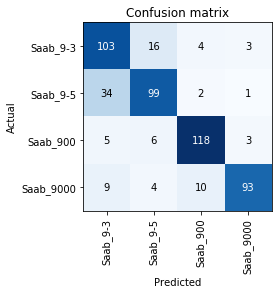

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Save and export the Learner

In [19]:
learn.save('saab-stage1')

In [20]:
learn.export('saab-classifier.pkl')

In [21]:
learn_inference = load_learner('saab-classifier.pkl')

In [22]:
### Build WebApp with Ipython Widgets

In [24]:
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
out_pl.clear_output()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inference.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])